# Clots Mentions Frequences: comparison between Vaccines

In [1]:
from tqdm import tqdm
import pandas as pd
from functools import reduce
from io import open
import json
from datetime import date,datetime, timedelta
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
df = pd.read_pickle("../full_db.pkl")

ANALYZE_DAYS = False

df = df[df.entities.str.len()>0]
df = df[~df.sentiment_value.isna()]
df = df[df.created_at < "2021-09-07"]

new_df = []
for idx, row in df.iterrows():
    d = row.to_dict()
    for vax in d["vaccines"]:
        d2 = d.copy()
        del d2["vaccines"]
        d2["vaccine_name"] = vax
        new_df.append(d2)
df = pd.DataFrame(new_df)

df.created_at = pd.to_datetime(df.created_at)
df["ym"] = df.created_at.astype(str).str[:-3]
df["roberta_label"] = df.sentiment_value.apply(lambda row: row["label"])

data = []
for _date, d in df[df.vaccine_name=="astrazeneca"].groupby("created_at"):
    
    vc = d.roberta_label.value_counts()
    
    item = {
        "date": _date,
        "pos_sum": vc["LABEL_2"] / len(d) if "LABEL_2" in vc else 0,
        "neu_sum": vc["LABEL_1"] / len(d) if "LABEL_1" in vc else 0,
        "neg_sum": vc["LABEL_0"] / len(d) if "LABEL_0" in vc else 0,
    }

    data.append(item)
    
data = pd.DataFrame(data)


data.index = data.date
data.drop("date", axis=1, inplace = True)


data["pos_ewm"] = data.pos_sum.ewm(halflife = "4 days", times=pd.DatetimeIndex(data.index)).mean()
data["neu_ewm"] = data.neu_sum.ewm(halflife = "4 days", times=pd.DatetimeIndex(data.index)).mean()
data["neg_ewm"] = data.neg_sum.ewm(halflife = "4 days", times=pd.DatetimeIndex(data.index)).mean()


In [6]:
ANALYZE_DAYS = False
PLOT_FREQ_OHTER = False
NORMALIZE_FREQ = False
# keep only the most important ones
VACCINES_TO_CHECK = ["astrazeneca", "pfizer", "moderna", "johnson & johnson"]
vaccines_color = {
    'astrazeneca': "coral",
    'pfizer': "mediumseagreen",
    'moderna': "#777",
    "johnson & johnson": 'cornflowerblue'
}

vaccines_names = {
    'astrazeneca': "AstraZeneca",
    'pfizer': "Pfizer",
    'moderna': "Moderna",
    "johnson & johnson": 'Johnson &\nJohnson'
}

In [7]:
df["norm_eng"] = df.entities.apply(lambda x: [ent["text"]["norm_eng"] for ent in x])

In [8]:
# calculate if there are some mentions of clots
# mask = [(df.norm_eng.str.contains(w)) for w in ["ischemic stroke", "ischemic", "ischemy", "ischemia", "ischaemia", "thrombosis", "embolism", "embolus", "ictus", "apoplexy", "blockage", "clotting", "coagulation", "coronary", "coronary thrombosis", "occlusion", "seizure", "clot", "blockade", "fit", "collapse", "CVA", "cerebrovascular accident", "cerebral vascular accident", "cerebral haemorrhage"]]
mask = [(df.norm_eng.apply(lambda x: w in x)) for w in ["ischemic stroke", "ischemic", "ischemy", "ischemia", "ischaemia", "thrombosis", "embolism", "embolus", "ictus", "apoplexy", "blockage", "clotting", "coagulation", "coronary", "coronary thrombosis", "occlusion", "seizure", "clot", "blockade", "fit", "collapse", "CVA", "cerebrovascular accident", "cerebral vascular accident", "cerebral haemorrhage"]]
mask = reduce(lambda x,y: x|y, mask, [False]*len(df))
df["clots_cit"] = mask

In [9]:
def get_interval_dates():

    sdate = date(2020, 12, 10)   # start date
    edate = date(2021, 9, 6)     # end date

    delta = edate - sdate       # as timedelta

    dates = []
    for i in range(delta.days + 1):
        new_date = sdate + timedelta(days=i)
        txt_date = f"{new_date.year}-{new_date.strftime('%m')}"
        if ANALYZE_DAYS:
            txt_date += f"-{new_date.strftime('%d')}"
        dates.append(txt_date)
    return list(set(dates))

In [10]:
# count frequencies for each vaccine
vaccines_dfs = df.groupby("vaccine_name")
dates =  sorted(get_interval_dates())
clots_cit = {}
tweet_per_day = {}

for vaccine_name, data in vaccines_dfs:
    if vaccine_name in VACCINES_TO_CHECK:
        clots_cit[vaccine_name] = {'date': [], 'freq_cit': [], 'freq_not_cit': []}
        months_dfs = data.groupby("ym")
        for _date in dates:
            exists_date = _date in months_dfs.groups.keys()
            if exists_date:
                d = months_dfs.get_group(_date)
                tweet_per_day[_date] = d[d.clots_cit].tweet_id.unique().shape[0] if _date not in tweet_per_day else (tweet_per_day[_date] + d[d.clots_cit].tweet_id.unique().shape[0])
            else:
                tweet_per_day[_date] = 0 if _date not in tweet_per_day else tweet_per_day[_date]

            clots_cit[vaccine_name]['date'].append(_date)
            clots_cit[vaccine_name]['freq_cit'].append((d[d.clots_cit].tweet_id.unique().shape[0] / (sum_freq_cit if NORMALIZE_FREQ else 1)) if exists_date else 0.0)
            clots_cit[vaccine_name]['freq_not_cit'].append((d[~d.clots_cit].tweet_id.unique().shape[0] / (sum_freq_cit if NORMALIZE_FREQ else 1)) if exists_date else 0.0)               
               

if not PLOT_FREQ_OHTER:
    for vaccine_name,_ in vaccines_dfs:
        if vaccine_name in VACCINES_TO_CHECK:
            for _date in dates:
                pos = clots_cit[vaccine_name]['date'].index(_date)
                clots_cit[vaccine_name]['freq_cit'][pos] /= (tweet_per_day[_date] if tweet_per_day[_date] != 0 else 1)
                

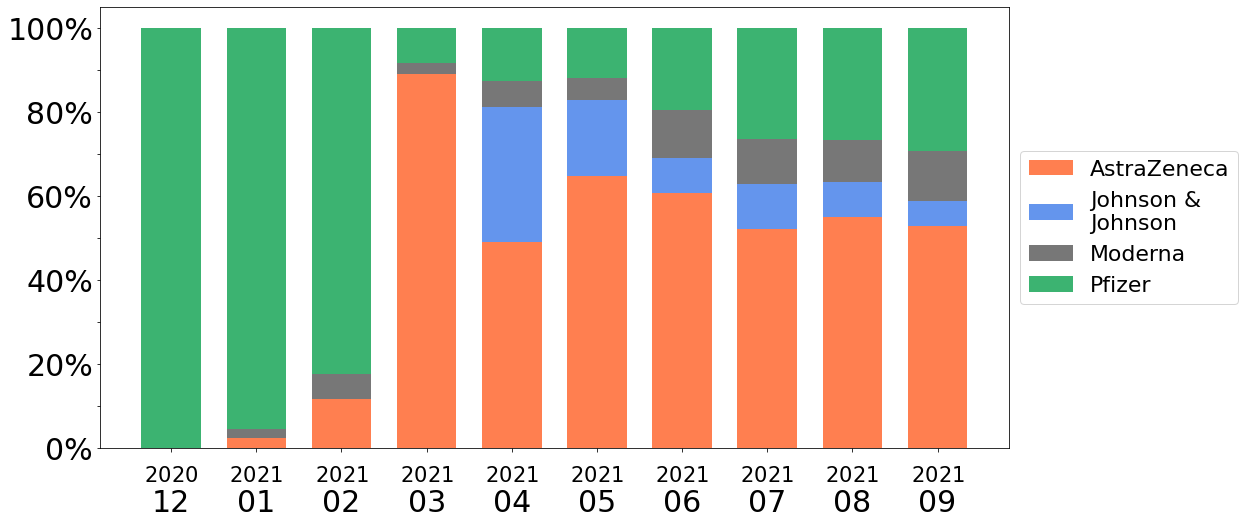

In [11]:
x_size = 100 if ANALYZE_DAYS else 18
x_dates = [f"$_{{{d.split('-')[0]}}}$\n{d.split('-')[1]}" for d in sorted(get_interval_dates())]

plt.rcParams.update({'font.size': 30})

plt.figure(figsize=(x_size,8))
last = [0]*len(x_dates)
for vaccine_name, freqs in clots_cit.items():
    if vaccine_name in VACCINES_TO_CHECK:
        plt.bar(x_dates, freqs['freq_cit'], label=vaccines_names[vaccine_name], bottom=last, color=vaccines_color[vaccine_name], width=0.7)
        last = [a+b for a,b in zip(last, freqs['freq_cit'])]
plt.legend(bbox_to_anchor=(1,.5), loc="center left", fontsize=22)
plt.xticks([_date for _date in x_dates])
plt.yticks([p/10 for p in range(0,11,1)], [f"{p}%" if p%20 == 0 else "" for p in range(0,110,10)])
plt.tight_layout()
plt.savefig("output/plot_clots_refs_between_vax.pdf")
plt.show()